In [1]:
import pandas as pd
import numpy as np
import tushare as ts

import seaborn
%matplotlib inline
from matplotlib import pyplot as plt


#### 1. 数据获取， 整理

In [2]:
stocks = ['601688', '601788'] #华泰证券 光大证券 / 同行业， 同类型的两只股票

In [3]:
stock1 = ts.get_k_data(stocks[0], '2016-08-13', '2020-08-13')[['date', 'close']]

In [4]:
stock2 = ts.get_k_data(stocks[1], '2016-08-13', '2020-08-13')[['date', 'close']]

In [5]:
stock_pair = pd.merge(stock1, stock2, how= 'left', on= 'date')

In [6]:
stock_pair.set_index('date', inplace = True)

In [7]:
stock_pair.columns = stocks

In [8]:
stock_pair.head()

,601688,601788
date,,
2016-08-15,20.535,17.839
2016-08-16,20.794,17.510
2016-08-17,20.353,17.336
2016-08-18,19.759,17.201
2016-08-19,19.855,17.230


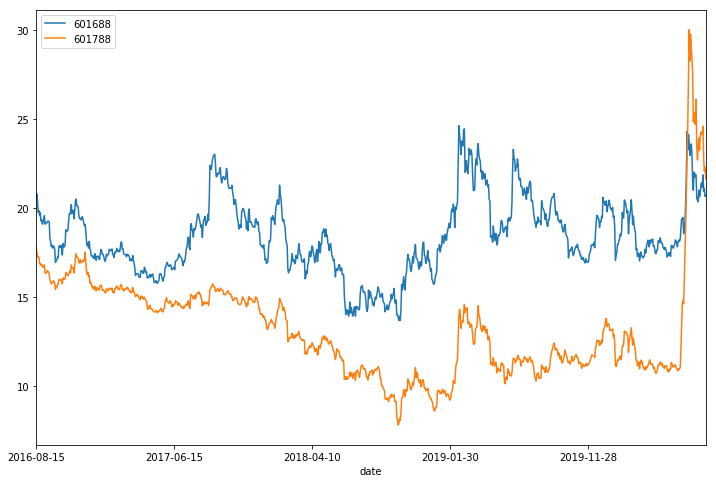

In [9]:
 stock_pair.plot(figsize = (12,8))

#### 2. 策略开发思路

In [10]:
stock_pair.corr()

,601688,601788
601688,1.000000,0.439504
601788,0.439504,1.000000


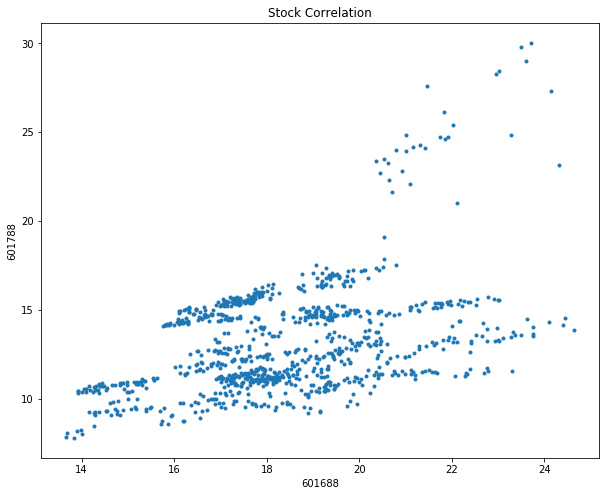

In [11]:
plt.figure(figsize =(10,8))
plt.title('Stock Correlation')
plt.plot(stock_pair[stocks[0]], stock_pair[stocks[1]], '.')
plt.xlabel(stocks[0])
plt.ylabel(stocks[1])
stock_pair.dropna(inplace = True)

In [12]:
[slope, intercept] = np.polyfit(stock_pair.iloc[:,0], stock_pair.iloc[:,1], 1).round(2)      
slope,intercept

(0.63, 1.71)

In [13]:
stock_pair['spread'] = stock_pair.iloc[:,1] - (stock_pair.iloc[:,0]*slope + intercept)

In [14]:
stock_pair.head()

,601688,601788,spread
date,,,
2016-08-15,20.535,17.839,3.19195
2016-08-16,20.794,17.510,2.69978
2016-08-17,20.353,17.336,2.80361
2016-08-18,19.759,17.201,3.04283
2016-08-19,19.855,17.230,3.01135


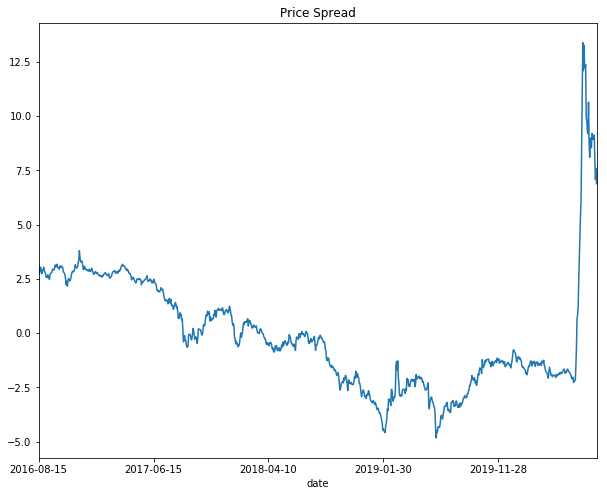

In [15]:
stock_pair['spread'].plot(figsize = (10,8),title = 'Price Spread')

In [16]:
stock_pair['zscore'] = (stock_pair['spread'] - stock_pair['spread'].mean())/stock_pair['spread'].std()

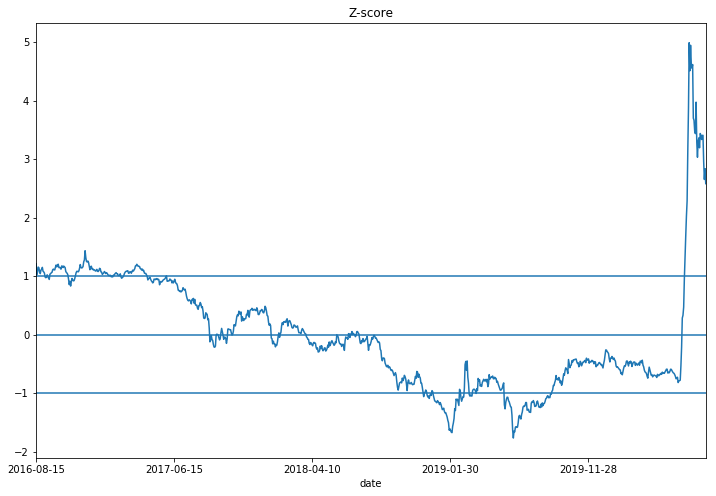

In [17]:
stock_pair['zscore'].plot(figsize = (12,8),title = 'Z-score')
plt.axhline(1)
plt.axhline(0)
plt.axhline(-1)

#### 3. 产生交易信号

In [18]:
stock_pair['position_1'] = np.where(stock_pair['zscore'] > 1, 1, np.nan)
stock_pair['position_1'] = np.where(stock_pair['zscore'] < -1, -1, stock_pair['position_1'])
stock_pair['position_1'] = np.where(abs(stock_pair['zscore']) < 0.5, 0, stock_pair['position_1'])

In [19]:
stock_pair['position_1'] = stock_pair['position_1'].fillna(method = 'ffill')

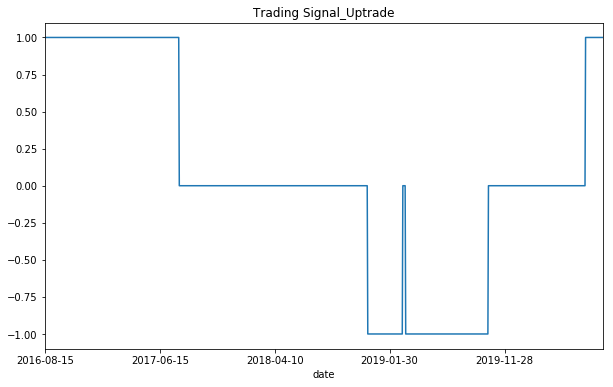

In [20]:
stock_pair['position_1'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Uptrade')

In [21]:
stock_pair['position_2'] = -np.sign(stock_pair['position_1'])

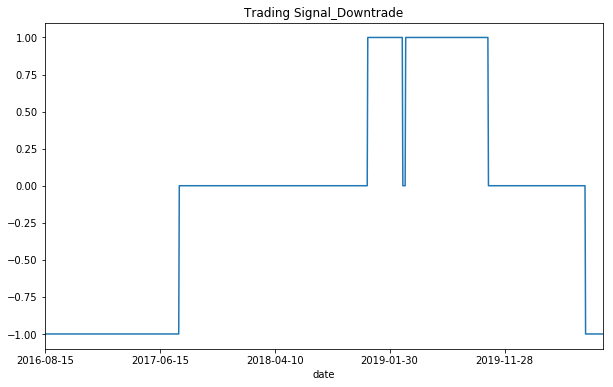

In [22]:
stock_pair['position_2'].plot(ylim=[-1.1, 1.1], figsize=(10, 6),title = 'Trading Signal_Downtrade')

### 4. 计算策略年化收益并可视化

In [23]:
stock_pair['returns_1'] = np.log(stock_pair[stocks[0]] / stock_pair[stocks[0]].shift(1))

In [24]:
stock_pair['returns_2'] = np.log(stock_pair[stocks[1]] / stock_pair[stocks[1]].shift(1))

In [25]:
stock_pair['strategy'] = 0.5*(stock_pair['position_1'].shift(1) * stock_pair['returns_1'])+0.5*(stock_pair['position_2'].shift(1) * stock_pair['returns_2'])

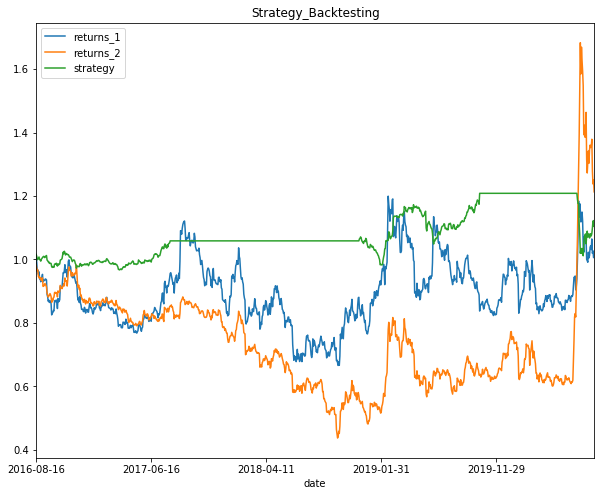

In [26]:
stock_pair[['returns_1','returns_2','strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 8),title = 'Strategy_Backtesting')